<a href="https://colab.research.google.com/github/Mjloturco/musicstreamnet/blob/main/Parallel_Input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiple Parallel Input

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from datetime import datetime 
import numpy as np 
import tensorflow as tf
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input, GRU
from keras.layers.merge import concatenate
from tensorflow.keras.models import Model 


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Data Preprocessing

### Time Series

In [4]:
# df = pd.read_csv('/content/drive/My Drive/cs137/project/spotify_daily_song_major.csv')
df = pd.read_csv('/content/drive/My Drive/cs137/project/spotify_daily_charts.csv')

In [5]:
df = df.drop(columns=['track_name', 'artist', 'position'])
df.head()

timesteps = df['date'].unique()

In [6]:
df_pivot = pd.pivot_table(df, values='streams', index=['date'], columns=['track_id'])
df_pivot.head()

track_id,000xQL6tZNLJzIrtIgxqSl,003eoIwxETJujVWmNFMoZy,007d7JT41sSc1HqWTs4uw7,0087fDVeNhuyMtST91RMjv,00bAw28lKcHj3B94a1wJle,00lNx0OcTJrS3MKHcB80HY,00mBzIWv5gHOYxwuEJXjOG,011GTFfE8rqTRMhz5g8IAW,017PF4Q3l4DBUiWoXk4OWT,01QdEx6kFr78ZejhQtWR5m,01YEqVPCm0vqRLA9w43bic,01dmH2IPkrLNWIMPNXlreE,01eo8yhZDkzYuog8FzYzgV,01iyINEYgPQ7ThMZuHUsqS,01k24g94i1JvkFLQmVEdCd,01uk7IzZyFNfQTDBXxx6NB,0247StOpd3AkeBQzANX4Zf,029B34AzPVXzOQCyaJpkdH,02FaKXXL7KUtRc7K0k54tL,02GtNoUv85fOPEaCTlpYzr,02WacdrRpm4zlP8H7X6bnQ,02q0ZnV2L4XByzEvWZJqBC,031mgKcbAk6cL9ZpfIEq4K,034KyQEk7IhbLtniVhBErj,03B2SfXuvDh1m9F4tqrX07,03T4ttRCiLXST6MZjeMwmR,03VNgdCL9t8aPyvwZecglI,03iCbZaM4OkRR4We6wIzvx,03o4HPzUwftpgAPNQSuaBS,03wvlNaxFKB9sge4U6vyPE,042x9bsUBWW2fJgJ6fUh61,045vckAeaQEbJ3vmatyBWt,04CttTezSnv71USiiG9mIo,04DwTuZ2VBdJCCC5TROn7L,04JL2liXXV9B9coeGuUsPw,04ZTP5KsCypmtCmQg5tH9R,051Z51PfIFgEe1gdo1vl6B,053ZzdU3Rya4NMxiWMPqnq,05ABOPiW13nqIedJfqmfPM,05CwHjIk71RXVU40boRMnR,05KOgYg8PGeJyyWBPi5ja8,05W4TSNqPEXtKdejLVRQrm,05mAIVLkIWc2d1UBYZBCp8,05mDaV9Vb3wrzjF6OPZnhq,06ANmvjPpUeh8QQAAAcThx,06FCvd7rrRcF3DdvWH5Isp,06Pvy98db25O7wlfFFFIRM,06Vthiq8nNDuT5nOcch535,06cUybZMETs4i3yQO1f7p3,073ILU1C3APNRGF66VhtyA,0742PcMPo2Akmo4vHC29VZ,07CYRI5dwRevOhthkHU58X,07JZJ9YJRaiUAz9Bv8wgwH,07KegcFokV4bBD1GvO1j6L,07MW63ok3ptSKwaTWEN0o8,07Oz5StQ7GRoygNLaXs2pd,07ipXN6CNTw34qwSYePKpg,07s9NNOT0sZQp7TyolLLgu,0815caqt2Lytro5EIzMufT,083Qf6hn6sFL6xiOHlZUyn,08LwMWf5Tcfsd752EPzFV0,08WPvDEsHvTFuB9w8tC2OS,08bNPGLD8AhKpnnERrAc6G,08fa9LFcFBTcilB3iq2e2A,08sQknOKXt3Thw6kw3pUu1,0939D7aT18uBDS2MTjWzct,09IStsImFySgyp0pIQdqAc,09KlDlkOYuC5x6hOaM7vaP,09PGubKAMryhOWv1LHpCYz,09oZ9eXQ2fo6YDrPzJqAoP,09ts3GnICqYEU5PkQCpJK3,0AG2l0IboWNSwjUkMr2Aq7,0ARK753YaiJbpLUk7z5yIM,0AZjL7QqObm13VxPA078uz,0AaV4MJrgmLV3XhoiWXjjb,0AiUFrU3Bj0ZzYFSWoAM0O,0Aii1ZdrQwkas2lrRFz6ZY,0AkQbXGN4KG34TS7xLrM68,0At2qAoaVjIwWNAqrscXli,0AtP8EkGPn6SwxKDaUuXec,0B0tYbVp7pDQAqKDhgMeaL,0B7wvvmu9EISAwZnOpjhNI,0B8B8cVRFIG1yznoQe7c9s,0BCPKOYdS2jbQ8iyB56Zns,0BEpSEV02FM1N5gcw2fsJC,0BOEuUKoHdy8in20fG5smd,0BSd5u6lQJWDoNVMuBYBiA,0BaMZMMEG7GWrUYsoGw8Yg,0BkKdJSpKqzYLEneerSHq3,0BlY60NrN0fFWbdW3RW40q,0BnTBAGmr9FtYwkZrwKhwS,0Bv25hxffynRiTkRvlPxw0,0C7RxcoJUdt0EDtQLuOFc6,0CBFOvHlyqy30Q5tbyNHfQ,0CLnkxpa3M4eA3HeGaERat,0CNjoQozZP0mB9rKVdrKGx,0CZ8lquoTX2Dkg7Ak2inwA,0CcQNd8CINkwQfe1RDtGV6,0ClPIeT6MSgfSgQ9ZrJbAq,0Clb9aiXWa0dvVff5aN4VN,0CokSRCu5hZgPxcZBaEzVE,0CyydmXI4QhgUWrZsPOTXA,0D4yVl9Pn45xW2s63MFCmT,0D8ZpOXVjapLXrjz5VfZSD,0DC7Zs2qvAbNK1owWQ4mlL,0DdC92EziGIEN6j7kTCKQX,0DhkTGjEaIHaSxTfC14BFm,0DiDStADDVh3SvAsoJAFMk,0Dljpp52vCmtXi0E94qjfo,0Dn40gxVCMo5TkgS8Ik18Q,0Dq49j3dELbttQVUJbtn0c,0E3LHQbZTPLyw06z6XvmNn,0E4Y1XIbs8GrAT1YqVy6dq,0E6PsO3ymCfUh7pJQjBgkj,0E8eAVCGmOk78xebmDEBfF,0E9ZjEAyAwOXZ7wJC0PD33,0EQMrxdeiBhry9JCxskko3,0EkPuwTCZxRPpOHT4AvGgE,0Eqg0CQ7bK3RQIMPw1A7pl,0ErjxyZ4qHQVs5umCBIClk,0ExtPzAWi4arQz6kaabm02,0F9Xy6OTbkqOv94pklkwKu,0FDzzruyVECATHXKHFs9eJ,0FMjqbY3aWo1QDbo3GwXib,0Fh6hgq979963fIxr2VBF2,0FuTx2s3YH1ppmtiM6l0zI,0G5qmu4TsdUH19zdcbI9Ui,0GGfPhGuWC2JGc7hlvjLXa,0GHR9XDrf3j7OI9GWy4915,0GHwNr0lqf8jpc9wesmnHo,0GOJobsbOSIF99y6CGr5o6,0GPJSHYaXh8rZSSJoUMgyl,0GU5GuJQQEnnREO2FxnVPT,0GUbhhI5fRx7BlqlqlhjuB,0GVKkD74xcixRYYG3zv1NL,0GVuLQtPXFaL18ijEOqoAa,0Gl5s8IhMmQE5YQwM8Qx1J,0GuAFGEkbWayjhWdlYlr7K,0GxQ1A5L9xnMOytbP6eKBG,0GxgZ6u2fZAsogiMs1rgMl,0GzuHFG4Ql6DoyxFRnIk3F,0H4ugk6rhnXmTl47ayy9O5,0HMjXBAZmSYOTTi33WpMso,0HQnJee8ShSDu2AYwibxst,0HVv5bEOiI9a0QfgcASXpX,0HYmOF3tCkYejosr1HTMhV,0HZ3OUVrGHxttD2EuHqRm3,0I20rLT2MJDhcF96AjbNYo,0I4W2KgA6nBaphEf6g8DLE,0I5Z0p0cLWdyJNC6sqMTwD,0IUksMHKob4SvJJL6QlQVi,0Ie5uiv54KgCr7P4sYDTHl,0IpbLjg5HE1Ju4k1rhYqvp,0Iu5xWN9wtWHp5daIj0Mjb,0JEqGkvUiMTQmFY6sgL9kg,0JM8LI4HxrQs2Reqr2naYo,0JP9xo3adEtGSdUEISiszL,0JQHGu03YJikcND4SENdiW,0JeDwT1t3gcrAH29RA0yvm,0JiVRyTJcJnmlwCZ854K4p,0Jlcvv8IykzHaSmj49uNW8,0JzwzRDkwZr8s1WRfNgUqA,0K2UmT0JOcEaLssWda2703,0KKkJNfGyhkQ5aFogxQAPU,0KR2W3St74th8z3LS94Ffh,0KaUTLgQTHW0hIRi9vuPEF,0KeZ6mv7rL5wfF7TuxSUdk,0KmgJyW4GDgonqsoyx0CZ3,0KoiMHhqKLoL4xM54rcWYY,0LAh3hfeuUekvLm3Nq6MmA,0LGCloCfw3fk1XQh0zbrs1,0LtVx5vsq9nfpGsWgjUin6,0Lw6aQcBFWTQ9m4MSwwwes,0M1A9wInEHil

In [7]:
# filter out songs without a lot of stream counts 
df_pivot = df_pivot.dropna(axis=1, thresh=800)

# fill NaN values with 0???
# df_pivot = df_pivot.fillna(0)
df_pivot = df_pivot.interpolate(method='linear', axis=1, limit=2)
df_pivot = df_pivot.fillna(0)

In [10]:
# pd.options.display.max_rows = None
# df_pivot.iloc[:, 1]

In [8]:
# get last 20% of songs
split = df['date'].unique()[-int(1598*0.2)]

df_train = df_pivot.loc[:split]
df_test = df_pivot.loc[split:]

In [9]:
# min-max scaling 

from sklearn.preprocessing import MinMaxScaler 

l = [i for i in df_pivot if i != 'date']

scaler = MinMaxScaler() 
scaled_train = scaler.fit_transform(df_train[l])
scaled_test = scaler.fit_transform(df_test[l])


In [10]:
def split_sequence(sequence, look_back, forecast_horizon):
  """
  splitting sequence
  """
  X, y = list(), list() 
  
  for i in range(len(sequence)):

    lag_end = i + look_back
    forecast_end = lag_end + forecast_horizon 

    if forecast_end > len(sequence):
      break 

    seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
    X.append(seq_x)
    y.append(seq_y)
  
  return np.array(X), np.array(y)


# splitting parameters 
LOOK_BACK = 2
FORECAST_RANGE = 1
n_features = len(l)

X_train, y_train = split_sequence(scaled_train, LOOK_BACK, FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, LOOK_BACK, FORECAST_RANGE)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(1278, 2, 63) (1278, 1, 63) (317, 2, 63) (317, 1, 63)


### Metadata

In [ ]:
meta = pd.read_csv('/content/drive/My Drive/cs137/project/spotify_tracks_augmented.csv').set_index('track_id')

# select only track IDs that we've filtered above 
meta = meta.loc[df_pivot.columns]


# drop columns 
dropcols = ['Unnamed: 0', 'artist_id', 'type', 'id', 'uri', 
            'track_href', 'analysis_url']

meta = meta.drop(columns=dropcols)

metasize = meta.shape[1]

# show metadata
print(meta.shape)
meta

## Model

In [11]:
# configure callbacks 

checkpoint_filepath = 'path_to_checkpoint_filepath'

checkpoint_callback = ModelCheckpoint(
 filepath=checkpoint_filepath,
 save_weights_only=False,
 monitor='val_loss',
 mode='min',
 save_best_only=True)

early_stopping_callback = EarlyStopping(
 monitor='val_loss',
 min_delta=0.005,
 patience=10,
 mode='min'
)

rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.001)

### Sequential GRU

In [12]:
EPOCHS = 100
BATCH_SIZE = 32
VALIDATION = 0.1 

# SEQUENTIAL MODEL 
gru_model = Sequential()
gru_model.add(GRU(X_train.shape[2], activation='relu'))
# gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mse')

gru_history = gru_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION, callbacks=[early_stopping_callback])

Epoch 1/100
36/36 [==============================] - 5s 20ms/step - loss: 0.0753 - val_loss: 0.0290
Epoch 2/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0502 - val_loss: 0.0287
Epoch 3/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0428 - val_loss: 0.0273
Epoch 4/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0418 - val_loss: 0.0258
Epoch 5/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0413 - val_loss: 0.0262
Epoch 6/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0410 - val_loss: 0.0260
Epoch 7/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0409 - val_loss: 0.0261
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0407 - val_loss: 0.0269
Epoch 9/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0405 - val_loss: 0.0264
Epoch 10/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0405 - val_loss: 0.0257
E

### Sequential LSTM

In [154]:
EPOCHS = 100
BATCH_SIZE = 32
VALIDATION = 0.1 
 # SEQUENTIAL MODEL 
seq_model = Sequential()
seq_model.add(LSTM(12, activation='relu', input_shape=(LOOK_BACK, n_features)))
seq_model.add(RepeatVector(FORECAST_RANGE))
seq_model.add(LSTM(12, activation='relu', return_sequences=True)) 
seq_model.add(TimeDistributed(Dense(n_features)))

seq_model.compile(optimizer='adam', loss='mse')

seq_history = seq_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION, callbacks=[early_stopping_callback])

Epoch 1/100
36/36 [==============================] - 3s 14ms/step - loss: 0.2049 - val_loss: 0.1009
Epoch 2/100
36/36 [==============================] - 0s 5ms/step - loss: 0.1531 - val_loss: 0.0599
Epoch 3/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0778 - val_loss: 0.0321
Epoch 4/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0356 - val_loss: 0.0328
Epoch 5/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0254 - val_loss: 0.0330
Epoch 6/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0202 - val_loss: 0.0291
Epoch 7/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0153 - val_loss: 0.0244
Epoch 8/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0125 - val_loss: 0.0225
Epoch 9/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0191
Epoch 10/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0176
Epoch 11

In [153]:
seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 12)                3648      
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 12)            0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 1, 12)             1200      
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 63)            819       
 tributed)                                                       
                                                                 
Total params: 5,667
Trainable params: 5,667
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 100
BATCH_SIZE = 32
VALIDATION = 0.1 

# SEQUENTIAL MODEL 
seq_model = Sequential()
seq_model.add(LSTM(12, activation='relu', input_shape=(LOOK_BACK, n_features)))
seq_model.add(RepeatVector(FORECAST_RANGE))
seq_model.add(LSTM(12, activation='relu', return_sequences=True)) 
seq_model.add(TimeDistributed(Dense(n_features)))

seq_model.compile(optimizer='adam', loss='mse')

seq_history = seq_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION, callbacks=[early_stopping_callback])

### Functional

In [29]:
swapped = np.swapaxes(meta, 0, 1)

swapped.shape

(13, 63)

In [107]:
y_train[:, 0, 1]

array([0.15871822, 0.12787845, 0.12587796, ..., 0.09610414, 0.10121977,
       0.13171639])

In [168]:

EPOCHS = 100
BATCH_SIZE = 32
VALIDATION = 0.1 

#                examples, timesteps, song
# input train shape (1265, 12, 63)
# train out         (1265, 4, 63) 
# test in           (304, 12, 63)
# test out          (304, 4, 63)

song_count = 63

# MODEL 
time_series_input = Input(shape=(12, song_count))
lstm_out_size = 63
lstm_out = LSTM(lstm_out_size)(time_series_input)
repeat_out = RepeatVector(FORECAST_RANGE)(lstm_out)
lstm2_out = LSTM(50, activation='relu', return_sequences=True)(repeat_out) 
dense_layer = Dense(song_count)
td_out = TimeDistributed(dense_layer)(lstm2_out)

# METADATA + concatenation
meta_input = Input(shape=(metasize, song_count))
full_features = concatenate([td_out, meta_input], axis=1)
swapped_features = tf.keras.layers.Permute((2, 1))(full_features)
d1 = Dense(16, activation='relu')(swapped_features) 
d2 = Dense(8, activation='tanh')(d1)
d3 = Dense(4, activation='tanh')(d2)
d4 = Dense(1, activation='linear')(d3)
# final = tf.keras.layers.Permute((2, 1))(d3)

# #outputshape
# output = Dense(1, activation='linear')(d1)

# # create model 
fun_model = Model(inputs=[time_series_input, meta_input], outputs=d4)

# # compile 
# model.compile(loss='mse', optimizer='adam')
fun_model.compile(optimizer='adam', loss='mse')

# stack metadata to match shape 
tiled = np.tile(np.swapaxes(np.expand_dims(meta, axis=0), 1, 2), [1268, 1, 1])

print(fun_model.summary())

X = [X_train[:, :, :song_count], tiled[:, :, :song_count]]
# Y = y_train[:, :, :song_count]
Y = np.swapaxes(y_train[:, :, :song_count], 1, 2)
fun_history = fun_model.fit(x=X, y=Y, 
                            epochs=EPOCHS, batch_size=BATCH_SIZE,
                            validation_split=VALIDATION, 
                            callbacks=[early_stopping_callback])

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_59 (InputLayer)          [(None, 12, 63)]     0           []                               
                                                                                                  
 lstm_62 (LSTM)                 (None, 63)           32004       ['input_59[0][0]']               
                                                                                                  
 repeat_vector_31 (RepeatVector  (None, 10, 63)      0           ['lstm_62[0][0]']                
 )                                                                                                
                                                                                                  
 lstm_63 (LSTM)                 (None, 10, 50)       22800       ['repeat_vector_31[0][0]']

In [160]:
print(yhat.shape)
print(X_train.shape, y_train.shape)

(307, 63, 1)
(1259, 12, 63) (1259, 10, 63)


## Evaluation

In [13]:
# pick which model we're evaluating 

# GRU
model = gru_model
history = gru_history 
test = X_test

# # LSTM 
# model = seq_model 
# history = seq_history 
# test = X_test

# only for functional model with metadata 
# print(X_test.shape, meta.shape)
# testmeta = np.tile(np.swapaxes(np.expand_dims(meta, axis=0), 1, 2), [298, 1, 1])
# print(testmeta.shape)

# test = [X_test, testmeta]


In [14]:
# Helper functions for model eval


def inverse_transform(y_test, yhat):
  """
  revert data back to original scale for evaluation
  """
  y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
  yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])

  yhat_inverse = scaler.inverse_transform(yhat_reshaped)
  y_test_inverse = scaler.inverse_transform(y_test_reshaped)

  return yhat_inverse, y_test_inverse 

  
def evaluate_forecast(y_test_inverse, yhat_inverse):
  """
  Evaluation metrics 
  """
  mse_ = tf.keras.losses.MeanSquaredError()
  rmse_ = tf.keras.metrics.RootMeanSquaredError()
  mae_ = tf.keras.losses.MeanAbsoluteError()
  mape_ = tf.keras.losses.MeanAbsolutePercentageError() 

  mse = mse_(y_test_inverse,yhat_inverse)
  # tf.print('mse:', mse)

  rmse = rmse_(y_test_inverse, yhat_inverse)
  # tf.print('rmse:', rmse)

  mae = mae_(y_test_inverse,yhat_inverse)
  # tf.print('mae:', mae)

  mape = mape_(y_test_inverse,yhat_inverse)
  # tf.print('mape:', mape)

  forecast = {'mse': mse.numpy(), 
              'rmse': rmse.numpy(),
              'mae': mae.numpy(), 
              'mape': mape.numpy()}
  return forecast



In [15]:
yhat = model.predict(test, verbose=0)

# fix this eventually to re-scale data 
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

# print(y_test_inverse.shape, yhat_inverse.shape, yhat.shape)
forecast = evaluate_forecast(y_test_inverse, yhat_inverse)

print(forecast)

{'mse': 217837760.0, 'rmse': 14759.327, 'mae': 11527.282, 'mape': 296270560000.0}


In [193]:
print(yhat_inverse.shape, y_test_inverse.shape, y_test.shape, yhat.shape)

(317, 7) (317, 7) (317, 1, 7) (317, 7)


In [165]:
# timesteps, batches?, songs 
print(yhat.shape)
print(yhat_inverse.shape)

(317, 7)
(317, 7)


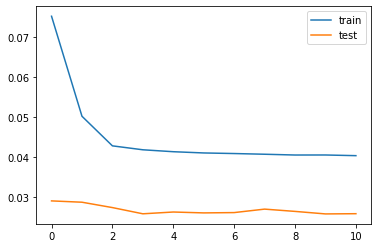

In [17]:
import matplotlib.pyplot as plt 

# visualize loss
f1 = plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()


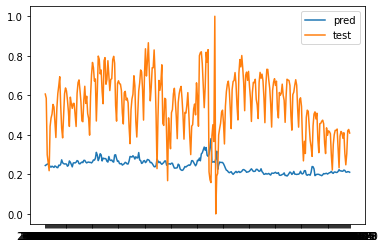

In [18]:
ntimesteps = yhat.shape[0]

song_idx = 2
fig, axs = plt.subplots(1, 1)
axs.plot(timesteps[-ntimesteps:], yhat[:, song_idx], label='pred')
axs.plot(timesteps[-ntimesteps:], y_test[:, 0, song_idx], label='test')

plt.legend()
plt.show()

In [ ]:
# plt.plot(timesteps[-304:], yhat, label='pred')
# plt.plot(timesteps[-304:], y_test, label='test') 
# plt.show()
plt.figure(figsize=(32, 32))

ntimesteps = yhat.shape[0]

fig, axs = plt.subplots(8, 8, figsize=(32, 32))
for i, ax in enumerate(axs.flat):
  # for lstm and functional models
  # ax.plot(timesteps[-ntimesteps:], yhat[:, 0, i-1], label='pred')
  # ax.plot(timesteps[-ntimesteps:], y_test[:, 0, i-1], label='test')

  # for GRU 
  ax.plot(timesteps[-ntimesteps:], yhat[:, i-1], label='pred')
  ax.plot(timesteps[-ntimesteps:], y_test[:, 0, i-1], label='test')

plt.legend()
plt.show()

# plt.plot(timesteps[-304:], yhat[:, 0, 16], label='pred')
# plt.plot(timesteps[-304:], y_test[:, 0, 16], label='test')
# plt.legend()
# plt.show()



### Visualize entire song!

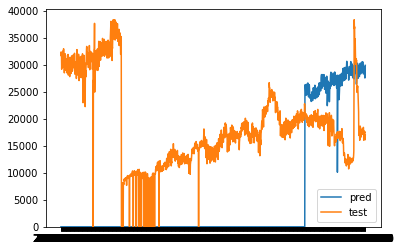

In [152]:
ntimesteps = yhat.shape[0]

# fitting entire song 
ytrn, ytst = inverse_transform(y_train, y_test)
pred_plt = np.pad(yhat_inverse, ((1278,0), (0, 0)), 'constant')
test_plt = np.append(ytrn, ytst, axis=0)

ntimesteps = 1595
# plot
song_idx = 0
fig, axs = plt.subplots(1, 1)
axs.plot(timesteps[-ntimesteps:], pred_plt[:, song_idx], label='pred')
axs.plot(timesteps[-ntimesteps:], test_plt[:, song_idx], label='test')

plt.ylim(bottom=0)
plt.legend()
plt.show()

In [ ]:
## BIIIG PLOT for entire song
plt.figure(figsize=(32, 32))

# ntimesteps = yhat.shape[0]
ntimesteps = 1579


# fitting entire song 
ytrn, ytst = inverse_transform(y_train, y_test)
pred_plt = np.pad(yhat_inverse, ((1270,0), (0, 0)), 'constant')
test_plt = np.append(ytrn, ytst, axis=0)

fig, axs = plt.subplots(8, 8, figsize=(32, 32))
for i, ax in enumerate(axs.flat):

  # normalized version
  ax.plot(timesteps[-ntimesteps:], pred_plt[:, i-1], label='pred')
  ax.plot(timesteps[-ntimesteps:], test_plt[:, i-1], label='test')
  ax.set_ylim([0, 100000])
 

plt.legend()
plt.show()

# PARAMETER SEARCHING

In [ ]:

# splitting parameters 
LOOK_BACK = 100
FORECAST_RANGE = 1
n_features = len(l)

EPOCHS = 100
BATCH_SIZE = 32
VALIDATION = 0.1 
  
EPOCHS = 100
BATCH_SIZE = 32
VALIDATION = 0.1 
 

rmse_dict = {}

for lb in range(2, 100):

  X_train, y_train = split_sequence(scaled_train, lb, FORECAST_RANGE)
  X_test, y_test = split_sequence(scaled_test, lb, FORECAST_RANGE)
   
  # SEQUENTIAL MODEL 
  gru_model = Sequential()
  gru_model.add(GRU(63, activation='relu'))
  # gru_model.add(Dense(1))
  
  gru_model.compile(optimizer='adam', loss='mse')
  
  gru_history = gru_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                      validation_split=VALIDATION, callbacks=[early_stopping_callback])
  
  
  yhat = gru_model.predict(X_test, verbose=0)
  yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
  eval = evaluate_forecast(y_test_inverse, yhat_inverse)
  
  rmse_dict[str(lb)] = eval['rmse']

  print('For look-back ', lb, ' RMSE is ', eval['rmse'])




In [77]:
min_rmse = min(rmse_dict.values())
res = [key for key in rmse_dict if rmse_dict[key] == min_rmse]

print(res, min_rmse)

['2'] 14317.2


In [7]:
"""
KEEP THIS!
results from parameter searching LOOK_BACK = range(2, 100) 
"""

rmse_dict = {'10': 16159.189,
 '11': 16107.495,
 '12': 17179.371,
 '13': 16777.184,
 '14': 17360.992,
 '15': 17064.346,
 '16': 16953.436,
 '17': 17597.09,
 '18': 16790.424,
 '19': 16580.441,
 '2': 14317.2,
 '20': 16959.75,
 '21': 17121.94,
 '22': 16855.826,
 '23': 16426.816,
 '24': 16492.117,
 '25': 17193.592,
 '26': 17511.111,
 '27': 17190.846,
 '28': 17534.877,
 '29': 17296.967,
 '3': 16040.876,
 '30': 17395.793,
 '31': 17003.795,
 '32': 15957.337,
 '33': 16711.143,
 '34': 16124.718,
 '35': 17420.363,
 '36': 16269.999,
 '37': 15740.73,
 '38': 17321.09,
 '39': 17751.826,
 '4': 16270.251,
 '40': 17172.14,
 '41': 16313.752,
 '42': 16520.643,
 '43': 18277.479,
 '44': 16308.43,
 '45': 17440.877,
 '46': 18022.148,
 '47': 16857.516,
 '48': 17083.777,
 '49': 16237.43,
 '5': 15872.009,
 '50': 15935.018,
 '51': 18147.082,
 '52': 16884.205,
 '53': 16176.652,
 '54': 17660.418,
 '55': 16555.408,
 '56': 17198.885,
 '57': 17154.646,
 '58': 16695.232,
 '59': 17501.258,
 '6': 15795.126,
 '60': 17035.416,
 '61': 18421.576,
 '62': 16830.66,
 '63': 17167.92,
 '64': 16714.412,
 '65': 17458.375,
 '66': 16663.982,
 '67': 16457.273,
 '68': 17521.68,
 '69': 17963.3,
 '7': 16767.715,
 '70': 17025.275,
 '71': 16949.191,
 '72': 17930.893,
 '73': 17257.988,
 '74': 17258.002,
 '75': 17789.861,
 '76': 16964.328,
 '77': 17495.078,
 '78': 17260.945,
 '79': 18044.9,
 '8': 16253.31,
 '80': 17520.803,
 '81': 16481.947,
 '82': 17445.463,
 '83': 17399.14,
 '84': 16131.646,
 '85': 16866.17,
 '86': 17812.592,
 '87': 16326.889,
 '88': 17095.916,
 '89': 16694.918,
 '9': 16272.523,
 '90': 16639.352,
 '91': 17189.988,
 '92': 16942.695,
 '93': 16344.626,
 '94': 17913.28,
 '95': 17860.457,
 '96': 16732.156,
 '97': 16267.522,
 '98': 16447.379,
 '99': 16750.906}


In [ ]:
# reformat and plot param search results for lookback
d = {int(k):v for k, v in rmse_dict.items()}
df = pd.DataFrame.from_dict(d, orient='index')
df.sort_index().plot()

In [138]:
print(len(timesteps))

ytrn, ytst = inverse_transform(y_train, y_test)
print(np.append(ytrn, ytst, axis=0).shape) # for 'test'
# print(np.pad(yhat_inverse, ((0, 0),(2, 0),(0, 0)), 'constant').shape)
print(np.pad(yhat_inverse, ((1270, 0), (0, 0)), 'constant').shape) # for 'pred'

1598
(1579, 7)
(1579, 7)


In [134]:
print(yhat_inverse.shape, y_test_inverse.shape)

(309, 7) (309, 7)


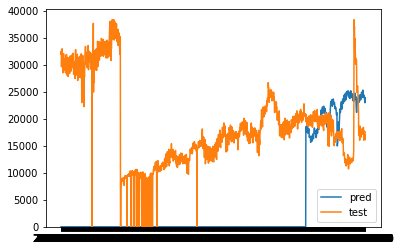

In [139]:
ntimesteps = yhat.shape[0]

# fitting entire song 
ytrn, ytst = inverse_transform(y_train, y_test)
pred_plt = np.pad(yhat_inverse, ((1270,0), (0, 0)), 'constant')
test_plt = np.append(ytrn, ytst, axis=0)

ntimesteps = 1579
# plot
song_idx = 0
fig, axs = plt.subplots(1, 1)
axs.plot(timesteps[-ntimesteps:], pred_plt[:, song_idx], label='pred')
axs.plot(timesteps[-ntimesteps:], test_plt[:, song_idx], label='test')

plt.ylim(bottom=0)
plt.legend()
plt.show()